In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import glob
from astropy.io import fits
import matplotlib.colors as col
import time
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema


In [2]:
def progress(file_count, total_files):
    print("\tFiles Completed: {}/{}".format(file_count, total_files), end="\r") 
    time.sleep(1)

In [3]:
#This Function Takes FITS data and pixel size to display Jet Length Info
def jet_length(data, pixel_size):
    
    #Creates list of slice sums
    slice_vals = []
    for row in data:
        slice_sum = 0
        for element in row:
            slice_sum += element
        slice_vals.append(slice_sum)
        
    #Creates list of Cumulative Sum values
    cul_vals = []
    movingsum = 0
    for element in slice_vals:
        movingsum += element
        cul_vals.append(movingsum)
        
    #Normalizes the Cumulative Values and creates list
    max_val = cul_vals[-1]
    norm_cul_vals = []
    norm = 0
    for element in cul_vals:
        norm = element / max_val
        norm_cul_vals.append(norm)
        
    #Edits the Normalizes Values to Exclude zeros and repeating terms
    final_reached = False
    norm_cul_vals_edit = []
    for element in norm_cul_vals:
        if element != 0 and final_reached is False:
            norm_cul_vals_edit.append(element)
        if element == 1:
            final_reached = True
        
    #Creates Value Headers for x-axis of histogram
    x_vals = []
    for x in range(len(norm_cul_vals_edit)):
        x_vals.append(x)
        
    x_vals_med = round(len(x_vals) / 2)
    x_vals_Q1 = round(np.median(x_vals[:x_vals_med]))
    x_vals_Q3 = round(np.median(x_vals[x_vals_med:]))
        
    smooth = gaussian_filter1d(norm_cul_vals_edit, 10)
    d1 = np.gradient(smooth)
    smooth_d1 = gaussian_filter1d(d1, 50)
    d2 = np.gradient(smooth_d1)
    smooth_d2 = gaussian_filter1d(d2, 100)
    d3 = np.gradient(smooth_d2)
    smooth_d3 = gaussian_filter1d(d3, 300)
    infls = np.where(np.diff(np.sign(smooth_d2)))[0]
    
    # for local maxima
    maxima_d2 = argrelextrema(smooth_d2, np.greater)
    # for local minima
    minima_d2 = argrelextrema(smooth_d2, np.less)
    
    
    norm_smooth_d1 = smooth_d1 / np.max(smooth_d1)
    norm_smooth_d2 = smooth_d2 / np.max(smooth_d2)
    norm_smooth_d3 = smooth_d3 / np.max(smooth_d3)
    
    #edited normalized cumulative histogram of data
#     plt.plot(x_vals, norm_cul_vals_edit, color='b', label = "raw")
#     #plt.plot(norm_smooth_d1, label='1st derivative', color = "g")
#     #plt.plot(norm_smooth_d2, label='2nd derivative', color = "orange")
#     #plt.plot(norm_smooth_d3, label='3rd derivative', color = "r")
#     labelcount = 0
#     for i, infl in enumerate(infls, 1):
#         if labelcount == 0:
#             plt.axvline(x=infl, color='k', linestyle='dashed', label="Inflection Points")
#         else:
#             plt.axvline(x=infl, color='k', linestyle='dashed')
#         labelcount += 1
#     plt.show()
        

    min_lst = []
    max_lst = []
    if len(maxima_d2) > 0:
        for element in maxima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='r', linestyle='dashed')
                    max_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
    if len(minima_d2) > 0:
        for element in minima_d2:
            for index in element:
                try:
                    #plt.axvline(x=index, color='y', linestyle='dashed')
                    min_lst.append(index)
                except ValueError:
                    print("Did not graph: {}".format(index))
                    
    
    #Determines and prints length of jet in pixels. Estimates to 0.98
    pixel_count = 0
    for element in norm_cul_vals_edit:
        if element >= 0.02 and element <= 0.98:
            pixel_count += 1
    

    #Converts pixel size to cm and prints
    jet_size_cm = pixel_size * pixel_count
    
    
    #Converts cm size to kpc and prints
    jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)
    
    lobe_dist_kpc = 0.0
    

    max_lst = sorted(max_lst)
    min_lst = sorted(min_lst)
    
    if (len(max_lst) + len(min_lst)) > 3:
        
        main_max = []
        main_min = []
        for point in max_lst:
            if point > x_vals_med and point < x_vals_Q3:
                main_max.append(point)
        for point in min_lst:
            if point > x_vals_Q1 and point < x_vals_med:
                main_min.append(point)
        
        try:
  
            slice_vals_edit = []
            flag = False
            for element in slice_vals:
                if flag is True:
                    slice_vals_edit.append(element)
                if element != 0 and flag is False:
                    flag = True
                    slice_vals_edit.append(element)

            for i in range(max(main_min), min(main_max)):
                slice_vals_edit[i] = float(0)

            lobe_dist = min(main_max) - max(main_min)

            cul_vals = []
            movingsum = 0
            for element in slice_vals_edit:
                movingsum += element
                cul_vals.append(movingsum)

            #Normalizes the Cumulative Values and creates list
            max_val = cul_vals[-1]
            norm_cul_vals = []
            norm = 0
            for element in cul_vals:
                norm = element / max_val
                norm_cul_vals.append(norm)

            #Edits the Normalizes Values to Exclude zeros and repeating terms
            final_reached = False
            norm_cul_vals_edit = []
            for element in norm_cul_vals:
                if element != 0 and final_reached is False:
                    norm_cul_vals_edit.append(element)
                if element == 1:
                    final_reached = True
                    
            pixel_count = 0
            for element in norm_cul_vals_edit:
                if element >= 0.02 and element <= 0.98:
                    pixel_count += 1

            #Converts pixel size to cm and prints
            jet_size_cm = pixel_size * pixel_count

            #Converts cm size to kpc and prints
            jet_size_kpc = round((jet_size_cm * 3.24077928967e-19) / 1e3, 4)

            lobe_dist_cm = lobe_dist * pixel_size
            lobe_dist_kpc = round((lobe_dist_cm * 3.24077928967e-19) / 1e3, 4)        
            
        except ValueError:
            p=0

    
        #Determines and prints length of jet in pixels. Estimates to 0.98
        

    
    return jet_size_kpc

In [4]:
#JET RESEMBLENSE
cen = 250


ratio_data_lst = {}
strengths = [430, 438, 446]

for stren in strengths:
    ratio_data = np.array([["Time", "Quad Value 1", "Quad Value 2", "Quad Ratio", "Hexa Value 1", "Hexa Value 2", "Hexa Ratio", "Octo Value 1", "Octo Value 2", "Jet Length (kpc)"]])
    path = '**/Group_L{}_*rc30_*nu=30.0*0.00_1.00_0.00*Myr.fits*'.format(stren)


    # Determines if there are any files in device
    total_files = len(glob.glob(path, recursive=True))

    if total_files > 0:
        file_count = 0
        progress(file_count, total_files)

        for file in sorted(glob.glob(path, recursive=True)):

            file_count += 1



            try:
                #print("File Number {}/{}\n".format(file_count, total_files))
                #print("File Name: {}".format(file))
                fits_image_hdul = fits.open(file)

                #Displays FITS Image title, time index, and pixel size
                sim_title = fits_image_hdul[0].header['OBJECT']
                sim_time = fits_image_hdul[0].header['TIME']
                sim_time = round(float(sim_time[:-4]), 1)


                pixel = fits_image_hdul[0].header['CDELT1']
                #print("Simulation Title: {}".format(sim_title))
                #print("Time index: {}".format(sim_time))
                #print("Pixel size: {}".format(pixel))
                pixel_size = float(pixel[:-3])

                #Difines Data From FITS image and records image dimensions
                data =  fits_image_hdul[0].data
                length = len(data[0])
                width = len(data)
                #print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))

                #hdr = fits_image_hdul[0].header
                #header = repr(hdr)
                #print(header)

                nx=length
                ny=width
                x=np.outer(np.linspace(-round(length/2),round(length/2),nx),np.ones(ny))
                y=np.outer(np.ones(nx),np.linspace(-round(width/2),round(width/2),ny))
                img=data

    #             image_data = fits.getdata(file, ext=0)
    #             for i in range(image_data.shape[0]):
    #                 for j in range(image_data.shape[1]):
    #                     if image_data[i, j] == 0:
    #                         image_data[i, j] = 1e-12


    #             plt.figure()
    #             plt.imshow(image_data, cmap='hot', norm=col.LogNorm())
    #             plt.clim(10e-11, 1e2) 
    #             plt.colorbar() 
    #             plt.show()

                # Quadruple moment:
                rsqr=x**2 + y**2
                q2=np.zeros([2,2])
                xy=[x,y]
                for i in [0,1]:
                    for j in [0,1]:
                        if i==j:
                            dij=1
                        else:
                            dij=0
                        q2[i,j]=1./2.*np.sum(img*(2*xy[i]*xy[j] - rsqr*dij))
                #print("\n\nQuadrupol moment:\n\n",q2/np.sum(img))

                q2_norm = q2/np.sum(img)


                # Octupole moment:

                q3=np.zeros([2,2,2])
                xy=[x,y]
                for i in [0,1]:
                    for j in [0,1]:
                        if i==j:
                            dij=1
                        else:
                            dij=0
                        for k in [0,1]:
                            if i==k:
                                dik=1
                            else:
                                dik=0
                            if j==k:
                                djk=1
                            else:
                                djk=0
                            q3[i,j,k]=1./2.*np.sum(img*(4*xy[i]*xy[j]*xy[k])) - np.sum(img*(rsqr*(xy[i]*djk + xy[j]*dik + xy[k]*dij)))

                q3_norm = q3/np.sum(img)
                #print("\n\nOctupolpol moment:\n\n",q3_norm)




                # Hexadecapole moment:

                q4=np.zeros([2,2,2,2])
                xy=[x,y]
                for i in [0,1]:
                    for j in [0,1]:
                        if i==j:
                            dij=1
                        else:
                            dij=0
                        for k in [0,1]:
                            if i==k:
                                dik=1
                            else:
                                dik=0
                            if j==k:
                                djk=1
                            else:
                                djk=0
                            for l in [0,1]:
                                if i==l:
                                    dil=1
                                else:
                                    dil=0
                                if j==l:
                                    djl=1
                                else:
                                    djl=0
                                if k==l:
                                    dkl=1
                                else:
                                    dkl=0
                                q4[i,j,k,l]=1./8.*np.sum(img*(24*xy[i]*xy[j]*xy[k]*xy[l] - 
                                                       4*rsqr*(xy[k]*xy[l]*dij + xy[j]*xy[l]*dik + xy[j]*xy[k]*dil + xy[i]*xy[l]*djk + xy[i]*xy[k]*djl + xy[i]*xy[j]*dkl)) +
                                                       img*(dij*dkl + dik*djl + dil*djk)*rsqr**2)

                #print("\n\nHexadecapol moment:\n\n",q4/np.sum(img))
                q4_norm =q4/np.sum(img)

                quad_val1 = q2_norm[0,0]
                quad_val2 = q2_norm[0,1]

                hexa_val1 = q4_norm[0,0,0,0]
                hexa_val2 = q4_norm[0,0,0,1]

                octo_val1 = q3_norm[0,0,1]
                octo_val2 = q3_norm[1,1,1]


                # if quad_val1 < -1e8:
                #     quad_val1 = 0
                # if quad_val2 < -1e8:
                #     quad_val2 = 0
                # if hexa_val1 < -1e8:
                #     hexa_val1 = 0
                # if hexa_val2 < -1e8:
                #     hexa_val2 = 0

                try:
                    quad_ratio = round(quad_val1/quad_val2, 4)
                except ZeroDivisionError:
                    quad_ratio = np.nan

                try:
                    hexa_ratio = round(hexa_val1/hexa_val2, 4)
                except ZeroDivisionError:
                    hexa_ratio = np.nan

                if abs(quad_ratio) > 50:
                    quad_ratio = np.nan
                if abs(hexa_ratio) > 50:
                    hexa_ratio = np.nan

                jet_size = jet_length(data, pixel_size)
                
                dis_data = np.array([sim_time, round(quad_val1, 4), round(quad_val2, 4), quad_ratio, round(hexa_val1, 4), round(hexa_val2, 4), hexa_ratio, round(octo_val1, 4), round(octo_val2, 4), jet_size])
                ratio_data = np.vstack([ratio_data, dis_data])

                #print("\n\n")


                #print("{}\n".format("_"*100))
                progress(file_count, total_files)

            except OSError:
                print("Error with file: {}".format(file))
                print("Empty or corrupt FITS file")

        data_table = pd.DataFrame(ratio_data)
        print("\nStrength L{}".format(stren))
        print(data_table)   
    
    ratio_data_lst[stren] = ratio_data


    # else:
    #     print("ERROR: Could not find any necessary files on your device")
    #     print("Program intakes files of the name: {}".format(path))





	Files Completed: 11/11
Strength L430
            0             1             2           3                  4  \
0        Time  Quad Value 1  Quad Value 2  Quad Ratio       Hexa Value 1   
1       1e+00      570.4639      -57.5011     -9.9209         967834.532   
2       2e+00     1545.6366      -45.7009    -33.8207       6273299.4987   
3       4e+00     2927.4579      -85.1389    -34.3845       22088852.907   
4       8e+00     4265.7695     -270.7997    -15.7525      51348019.0662   
5     1.6e+01     7985.8818      -52.7231         nan     185608451.8098   
6     3.2e+01    17628.2774      998.8298     17.6489     827949223.8741   
7     6.4e+01    36376.7926     1799.2696     20.2175    3264558033.9263   
8       8e+01    50749.7257     2429.1281     20.8922    6106005287.9555   
9    1.12e+02     95950.644     5596.3539     17.1452   18484409277.2401   
10  1.276e+02   119997.5546     7225.2506     16.6081   28419710209.3213   
11  2.376e+02   354675.0951    30025.6798     11.8

430
438
446


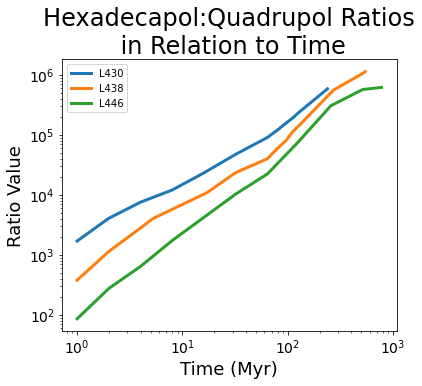

In [18]:



for key in ratio_data_lst:
    print(key)
    stren = key
    ratio_data = ratio_data_lst[key]

    plt.rcParams["figure.figsize"] = (6,5)
    rot_vals = ratio_data[1:, 0]
    quad1 = ratio_data[1:, 1]
    quad2 = ratio_data[1:, 2]
    quad_vals = ratio_data[1:, 3]
    hexa1 = ratio_data[1:, 4]
    hexa2 = ratio_data[1:, 5]
    hexa_vals = ratio_data[1:, 6]
    octo1 = ratio_data[1:, 7]
    octo2 = ratio_data[1:, 8]
    jet_len = ratio_data[1:, 9]

    len_vals_flt = []
    rot_vals_flt = []
    quad_vals_flt = []
    hexa_vals_flt = []
    quad1_flt = []
    quad2_flt = []
    hexa1_flt = []
    hexa2_flt = []
    octo1_flt = []
    octo2_flt = []



    for i, ratio in enumerate(quad_vals):
        dispers = float(rot_vals[i])
        lens = float(jet_len[i])
        ratio = float(ratio)
        rot_vals_flt.append(dispers)
        len_vals_flt.append(lens)
        quad_vals_flt.append(ratio)

    for ratio in hexa_vals:
        ratio = float(ratio)
        hexa_vals_flt.append(ratio)

    for ratio in quad1:
        ratio = float(ratio)
        quad1_flt.append(ratio)

    for ratio in quad2:
        ratio = float(ratio)
        quad2_flt.append(ratio)

    for ratio in hexa1:
        ratio = float(ratio)
        hexa1_flt.append(ratio)

    for ratio in hexa2:
        ratio = float(ratio)
        hexa2_flt.append(ratio)

#     for ratio in octo1:
#         ratio = float(ratio)
#         octo1_flt.append(ratio)

#     for ratio in octo2:
#         ratio = float(ratio)
#         octo2_flt.append(ratio)

    sq_flt = []
    for i in range(len(quad1_flt)):
        sq = math.sqrt(quad1_flt[i]**2 + quad2_flt[i]**2)
        sq_flt.append(sq)

    sq_hexa_flt = []
    for i in range(len(hexa1_flt)):
        sq = math.sqrt(hexa1_flt[i]**2 + hexa2_flt[i]**2)
        sq_hexa_flt.append(sq)
        
    sq_ratio_flt = []
    for i in range(len(sq_hexa_flt)):
        sq_ratio = sq_hexa_flt[i] / sq_flt[i]
        sq_ratio_flt.append(sq_ratio)
    
    
    plt.plot(rot_vals_flt, sq_ratio_flt, label = "L{}".format(stren), linewidth=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Time (Myr)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel("Ratio Value", fontsize=18)
    plt.yticks(fontsize=14)
    plt.title("Hexadecapol:Quadrupol Ratios\n in Relation to Time", fontsize=24)
    
    plt.legend()
    
plt.show()



430
438
446


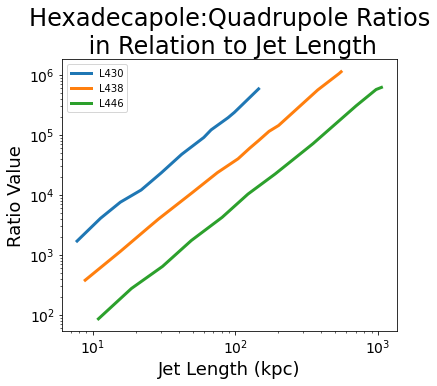

In [17]:



for key in ratio_data_lst:
    print(key)
    stren = key
    ratio_data = ratio_data_lst[key]

    plt.rcParams["figure.figsize"] = (6,5)
    rot_vals = ratio_data[1:, 0]
    quad1 = ratio_data[1:, 1]
    quad2 = ratio_data[1:, 2]
    quad_vals = ratio_data[1:, 3]
    hexa1 = ratio_data[1:, 4]
    hexa2 = ratio_data[1:, 5]
    hexa_vals = ratio_data[1:, 6]
    octo1 = ratio_data[1:, 7]
    octo2 = ratio_data[1:, 8]
    jet_len = ratio_data[1:, 9]

    len_vals_flt = []
    rot_vals_flt = []
    quad_vals_flt = []
    hexa_vals_flt = []
    quad1_flt = []
    quad2_flt = []
    hexa1_flt = []
    hexa2_flt = []
    octo1_flt = []
    octo2_flt = []



    for i, ratio in enumerate(quad_vals):
        dispers = float(rot_vals[i])
        lens = float(jet_len[i])
        ratio = float(ratio)
        rot_vals_flt.append(dispers)
        len_vals_flt.append(lens)
        quad_vals_flt.append(ratio)

    for ratio in hexa_vals:
        ratio = float(ratio)
        hexa_vals_flt.append(ratio)

    for ratio in quad1:
        ratio = float(ratio)
        quad1_flt.append(ratio)

    for ratio in quad2:
        ratio = float(ratio)
        quad2_flt.append(ratio)

    for ratio in hexa1:
        ratio = float(ratio)
        hexa1_flt.append(ratio)

    for ratio in hexa2:
        ratio = float(ratio)
        hexa2_flt.append(ratio)

#     for ratio in octo1:
#         ratio = float(ratio)
#         octo1_flt.append(ratio)

#     for ratio in octo2:
#         ratio = float(ratio)
#         octo2_flt.append(ratio)

    sq_flt = []
    for i in range(len(quad1_flt)):
        sq = math.sqrt(quad1_flt[i]**2 + quad2_flt[i]**2)
        sq_flt.append(sq)

    sq_hexa_flt = []
    for i in range(len(hexa1_flt)):
        sq = math.sqrt(hexa1_flt[i]**2 + hexa2_flt[i]**2)
        sq_hexa_flt.append(sq)
        
    sq_ratio_flt = []
    for i in range(len(sq_hexa_flt)):
        sq_ratio = sq_hexa_flt[i] / sq_flt[i]
        sq_ratio_flt.append(sq_ratio)
    
    
    plt.plot(len_vals_flt, sq_ratio_flt, label = "L{}".format(stren), linewidth=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Jet Length (kpc)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel("Ratio Value", fontsize=18)
    plt.yticks(fontsize=14)
    plt.title("Hexadecapole:Quadrupole Ratios\n in Relation to Jet Length", fontsize=24)
    
    plt.legend()
    
plt.show()



430
438
446


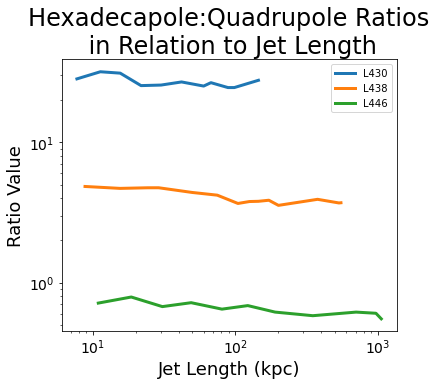

In [15]:



for key in ratio_data_lst:
    print(key)
    stren = key
    ratio_data = ratio_data_lst[key]

    plt.rcParams["figure.figsize"] = (6,5)
    rot_vals = ratio_data[1:, 0]
    quad1 = ratio_data[1:, 1]
    quad2 = ratio_data[1:, 2]
    quad_vals = ratio_data[1:, 3]
    hexa1 = ratio_data[1:, 4]
    hexa2 = ratio_data[1:, 5]
    hexa_vals = ratio_data[1:, 6]
    octo1 = ratio_data[1:, 7]
    octo2 = ratio_data[1:, 8]
    jet_len = ratio_data[1:, 9]

    len_vals_flt = []
    rot_vals_flt = []
    quad_vals_flt = []
    hexa_vals_flt = []
    quad1_flt = []
    quad2_flt = []
    hexa1_flt = []
    hexa2_flt = []
    octo1_flt = []
    octo2_flt = []



    for i, ratio in enumerate(quad_vals):
        dispers = float(rot_vals[i])
        lens = float(jet_len[i])
        ratio = float(ratio)
        rot_vals_flt.append(dispers)
        len_vals_flt.append(lens)
        quad_vals_flt.append(ratio)

    for ratio in hexa_vals:
        ratio = float(ratio)
        hexa_vals_flt.append(ratio)

    for ratio in quad1:
        ratio = float(ratio)
        quad1_flt.append(ratio)

    for ratio in quad2:
        ratio = float(ratio)
        quad2_flt.append(ratio)

    for ratio in hexa1:
        ratio = float(ratio)
        hexa1_flt.append(ratio)

    for ratio in hexa2:
        ratio = float(ratio)
        hexa2_flt.append(ratio)

#     for ratio in octo1:
#         ratio = float(ratio)
#         octo1_flt.append(ratio)

#     for ratio in octo2:
#         ratio = float(ratio)
#         octo2_flt.append(ratio)

    sq_flt = []
    for i in range(len(quad1_flt)):
        sq = math.sqrt(quad1_flt[i]**2 + quad2_flt[i]**2)
        sq_flt.append(sq)

    sq_hexa_flt = []
    for i in range(len(hexa1_flt)):
        sq = math.sqrt(hexa1_flt[i]**2 + hexa2_flt[i]**2)
        sq_hexa_flt.append(sq)
        
    sq_ratio_flt = []
    for i in range(len(sq_hexa_flt)):
        sq_ratio = sq_hexa_flt[i] / sq_flt[i]
        try:
            sq_ratio_div = sq_ratio / (len_vals_flt[i]**2)
        except ZeroDivisionError:
            sq_ratio_div = sq_ratio
        sq_ratio_flt.append(sq_ratio_div)
    
    
    plt.plot(len_vals_flt, sq_ratio_flt, label = "L{}".format(stren), linewidth=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Jet Length (kpc)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel("Ratio Value", fontsize=18)
    plt.yticks(fontsize=14)
    plt.title("Hexadecapole:Quadrupole Ratios\n in Relation to Jet Length", fontsize=24)
    
    plt.legend()
    
plt.show()



In [8]:
#JET RESEMBLENSE
cen = 250


ratio_data_lst_rc = {}
rc_vals = [3, 10, 30, 100]

for rc in rc_vals:
    ratio_data_rc = np.array([["Time", "Quad Value 1", "Quad Value 2", "Quad Ratio", "Hexa Value 1", "Hexa Value 2", "Hexa Ratio", "Octo Value 1", "Octo Value 2", "Jet Length (kpc)"]])
    path = '**/Group_L438_*rc{}_*nu=30.0*0.00_1.00_0.00*Myr.fits*'.format(rc)


    # Determines if there are any files in device
    total_files = len(glob.glob(path, recursive=True))

    if total_files > 0:
        file_count = 0
        progress(file_count, total_files)

        for file in sorted(glob.glob(path, recursive=True)):

            file_count += 1



            try:
                #print("File Number {}/{}\n".format(file_count, total_files))
                #print("File Name: {}".format(file))
                fits_image_hdul = fits.open(file)

                #Displays FITS Image title, time index, and pixel size
                sim_title = fits_image_hdul[0].header['OBJECT']
                sim_time = fits_image_hdul[0].header['TIME']
                sim_time = round(float(sim_time[:-4]), 1)


                pixel = fits_image_hdul[0].header['CDELT1']
                #print("Simulation Title: {}".format(sim_title))
                #print("Time index: {}".format(sim_time))
                #print("Pixel size: {}".format(pixel))
                pixel_size = float(pixel[:-3])

                #Difines Data From FITS image and records image dimensions
                data =  fits_image_hdul[0].data
                length = len(data[0])
                width = len(data)
                #print("FITS Image Dimensions: {}x{} pixels \n".format(length, width))

                #hdr = fits_image_hdul[0].header
                #header = repr(hdr)
                #print(header)

                nx=length
                ny=width
                x=np.outer(np.linspace(-round(length/2),round(length/2),nx),np.ones(ny))
                y=np.outer(np.ones(nx),np.linspace(-round(width/2),round(width/2),ny))
                img=data

    #             image_data = fits.getdata(file, ext=0)
    #             for i in range(image_data.shape[0]):
    #                 for j in range(image_data.shape[1]):
    #                     if image_data[i, j] == 0:
    #                         image_data[i, j] = 1e-12


    #             plt.figure()
    #             plt.imshow(image_data, cmap='hot', norm=col.LogNorm())
    #             plt.clim(10e-11, 1e2) 
    #             plt.colorbar() 
    #             plt.show()

                # Quadruple moment:
                rsqr=x**2 + y**2
                q2=np.zeros([2,2])
                xy=[x,y]
                for i in [0,1]:
                    for j in [0,1]:
                        if i==j:
                            dij=1
                        else:
                            dij=0
                        q2[i,j]=1./2.*np.sum(img*(2*xy[i]*xy[j] - rsqr*dij))
                #print("\n\nQuadrupol moment:\n\n",q2/np.sum(img))

                q2_norm = q2/np.sum(img)


                # Octupole moment:

                q3=np.zeros([2,2,2])
                xy=[x,y]
                for i in [0,1]:
                    for j in [0,1]:
                        if i==j:
                            dij=1
                        else:
                            dij=0
                        for k in [0,1]:
                            if i==k:
                                dik=1
                            else:
                                dik=0
                            if j==k:
                                djk=1
                            else:
                                djk=0
                            q3[i,j,k]=1./2.*np.sum(img*(4*xy[i]*xy[j]*xy[k])) - np.sum(img*(rsqr*(xy[i]*djk + xy[j]*dik + xy[k]*dij)))

                q3_norm = q3/np.sum(img)
                #print("\n\nOctupolpol moment:\n\n",q3_norm)




                # Hexadecapole moment:

                q4=np.zeros([2,2,2,2])
                xy=[x,y]
                for i in [0,1]:
                    for j in [0,1]:
                        if i==j:
                            dij=1
                        else:
                            dij=0
                        for k in [0,1]:
                            if i==k:
                                dik=1
                            else:
                                dik=0
                            if j==k:
                                djk=1
                            else:
                                djk=0
                            for l in [0,1]:
                                if i==l:
                                    dil=1
                                else:
                                    dil=0
                                if j==l:
                                    djl=1
                                else:
                                    djl=0
                                if k==l:
                                    dkl=1
                                else:
                                    dkl=0
                                q4[i,j,k,l]=1./8.*np.sum(img*(24*xy[i]*xy[j]*xy[k]*xy[l] - 
                                                       4*rsqr*(xy[k]*xy[l]*dij + xy[j]*xy[l]*dik + xy[j]*xy[k]*dil + xy[i]*xy[l]*djk + xy[i]*xy[k]*djl + xy[i]*xy[j]*dkl)) +
                                                       img*(dij*dkl + dik*djl + dil*djk)*rsqr**2)

                #print("\n\nHexadecapol moment:\n\n",q4/np.sum(img))
                q4_norm =q4/np.sum(img)

                quad_val1 = q2_norm[0,0]
                quad_val2 = q2_norm[0,1]

                hexa_val1 = q4_norm[0,0,0,0]
                hexa_val2 = q4_norm[0,0,0,1]

                octo_val1 = q3_norm[0,0,1]
                octo_val2 = q3_norm[1,1,1]


                # if quad_val1 < -1e8:
                #     quad_val1 = 0
                # if quad_val2 < -1e8:
                #     quad_val2 = 0
                # if hexa_val1 < -1e8:
                #     hexa_val1 = 0
                # if hexa_val2 < -1e8:
                #     hexa_val2 = 0

                try:
                    quad_ratio = round(quad_val1/quad_val2, 4)
                except ZeroDivisionError:
                    quad_ratio = np.nan

                try:
                    hexa_ratio = round(hexa_val1/hexa_val2, 4)
                except ZeroDivisionError:
                    hexa_ratio = np.nan

                if abs(quad_ratio) > 50:
                    quad_ratio = np.nan
                if abs(hexa_ratio) > 50:
                    hexa_ratio = np.nan

                jet_size = jet_length(data, pixel_size)
                
                dis_data = np.array([sim_time, round(quad_val1, 4), round(quad_val2, 4), quad_ratio, round(hexa_val1, 4), round(hexa_val2, 4), hexa_ratio, round(octo_val1, 4), round(octo_val2, 4), jet_size])
                ratio_data_rc = np.vstack([ratio_data_rc, dis_data])

                #print("\n\n")


                #print("{}\n".format("_"*100))
                progress(file_count, total_files)

            except OSError:
                print("Error with file: {}".format(file))
                print("Empty or corrupt FITS file")

        data_table = pd.DataFrame(ratio_data)
        print("\nDensity: rc{}".format(rc))
        print(data_table)   
    
    ratio_data_lst_rc[rc] = ratio_data_rc


    # else:
    #     print("ERROR: Could not find any necessary files on your device")
    #     print("Program intakes files of the name: {}".format(path))




	Files Completed: 11/11
Density: rc3
            0             1             2           3                  4  \
0        Time  Quad Value 1  Quad Value 2  Quad Ratio       Hexa Value 1   
1       1e+00       22.4504       -1.6868    -13.3098          1906.6139   
2       2e+00       84.4812          1.63         nan          23055.025   
3       4e+00      216.4836      -18.9241    -11.4396        133914.2578   
4       8e+00      720.2311      -43.6901     -16.485       1246651.8901   
5     1.6e+01     1557.0252       53.6864     29.0022        6529173.377   
6     3.2e+01     4210.0931      293.7241     14.3335      42794216.0374   
7     6.4e+01    11937.2662      393.6218     30.3267      265942677.013   
8   1.212e+02    33611.0085      326.4208         nan    2390865366.0971   
9   2.561e+02   128957.1875    -5977.2715    -21.5746   38967906024.6873   
10  5.131e+02   273408.4913    -2845.8736         nan  155137950155.2662   
11  7.731e+02   119924.8296     -476.2927         n

/tmp/ipykernel_11499/2225721921.py:82: RuntimeWarning: overflow encountered in multiply
  q2[i,j]=1./2.*np.sum(img*(2*xy[i]*xy[j] - rsqr*dij))
/tmp/ipykernel_11499/2225721921.py:82: RuntimeWarning: invalid value encountered in multiply
  q2[i,j]=1./2.*np.sum(img*(2*xy[i]*xy[j] - rsqr*dij))
/tmp/ipykernel_11499/2225721921.py:107: RuntimeWarning: overflow encountered in multiply
  q3[i,j,k]=1./2.*np.sum(img*(4*xy[i]*xy[j]*xy[k])) - np.sum(img*(rsqr*(xy[i]*djk + xy[j]*dik + xy[k]*dij)))
/tmp/ipykernel_11499/2225721921.py:107: RuntimeWarning: invalid value encountered in multiply
  q3[i,j,k]=1./2.*np.sum(img*(4*xy[i]*xy[j]*xy[k])) - np.sum(img*(rsqr*(xy[i]*djk + xy[j]*dik + xy[k]*dij)))
/tmp/ipykernel_11499/2225721921.py:147: RuntimeWarning: invalid value encountered in multiply
  q4[i,j,k,l]=1./8.*np.sum(img*(24*xy[i]*xy[j]*xy[k]*xy[l] -
/tmp/ipykernel_11499/2225721921.py:149: RuntimeWarning: overflow encountered in multiply
  img*(dij*dkl + dik*djl + dil*djk)*rsqr**2)
/tmp/ipykernel_1149

	Files Completed: 9/9
Density: rc10
            0             1             2           3                  4  \
0        Time  Quad Value 1  Quad Value 2  Quad Ratio       Hexa Value 1   
1       1e+00       22.4504       -1.6868    -13.3098          1906.6139   
2       2e+00       84.4812          1.63         nan          23055.025   
3       4e+00      216.4836      -18.9241    -11.4396        133914.2578   
4       8e+00      720.2311      -43.6901     -16.485       1246651.8901   
5     1.6e+01     1557.0252       53.6864     29.0022        6529173.377   
6     3.2e+01     4210.0931      293.7241     14.3335      42794216.0374   
7     6.4e+01    11937.2662      393.6218     30.3267      265942677.013   
8   1.212e+02    33611.0085      326.4208         nan    2390865366.0971   
9   2.561e+02   128957.1875    -5977.2715    -21.5746   38967906024.6873   
10  5.131e+02   273408.4913    -2845.8736         nan  155137950155.2662   
11  7.731e+02   119924.8296     -476.2927         na

3
10
30
100


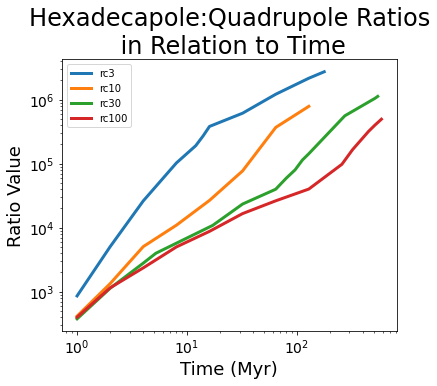

In [19]:



for key in ratio_data_lst_rc:
    print(key)
    rc = key
    ratio_data = ratio_data_lst_rc[key]

    plt.rcParams["figure.figsize"] = (6,5)
    rot_vals = ratio_data[1:, 0]
    quad1 = ratio_data[1:, 1]
    quad2 = ratio_data[1:, 2]
    quad_vals = ratio_data[1:, 3]
    hexa1 = ratio_data[1:, 4]
    hexa2 = ratio_data[1:, 5]
    hexa_vals = ratio_data[1:, 6]
    octo1 = ratio_data[1:, 7]
    octo2 = ratio_data[1:, 8]


    rot_vals_flt = []
    quad_vals_flt = []
    hexa_vals_flt = []
    quad1_flt = []
    quad2_flt = []
    hexa1_flt = []
    hexa2_flt = []
    octo1_flt = []
    octo2_flt = []



    for i, ratio in enumerate(quad_vals):
        dispers = float(rot_vals[i])
        ratio = float(ratio)
        rot_vals_flt.append(dispers)
        quad_vals_flt.append(ratio)

    for ratio in hexa_vals:
        ratio = float(ratio)
        hexa_vals_flt.append(ratio)

    for ratio in quad1:
        ratio = float(ratio)
        quad1_flt.append(ratio)

    for ratio in quad2:
        ratio = float(ratio)
        quad2_flt.append(ratio)

    for ratio in hexa1:
        ratio = float(ratio)
        hexa1_flt.append(ratio)

    for ratio in hexa2:
        ratio = float(ratio)
        hexa2_flt.append(ratio)

#     for ratio in octo1:
#         ratio = float(ratio)
#         octo1_flt.append(ratio)

#     for ratio in octo2:
#         ratio = float(ratio)
#         octo2_flt.append(ratio)

    sq_flt = []
    for i in range(len(quad1_flt)):
        sq = math.sqrt(quad1_flt[i]**2 + quad2_flt[i]**2)
        sq_flt.append(sq)

    sq_hexa_flt = []
    for i in range(len(hexa1_flt)):
        sq = math.sqrt(hexa1_flt[i]**2 + hexa2_flt[i]**2)
        sq_hexa_flt.append(sq)
        
    sq_ratio_flt = []
    for i in range(len(sq_hexa_flt)):
        sq_ratio = sq_hexa_flt[i] / sq_flt[i]
        sq_ratio_flt.append(sq_ratio)
    
    
    plt.plot(rot_vals_flt, sq_ratio_flt, label = "rc{}".format(rc), linewidth=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Time (Myr)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel("Ratio Value", fontsize=18)
    plt.yticks(fontsize=14)
    plt.title("Hexadecapole:Quadrupole Ratios\n in Relation to Time", fontsize=24)
    
    plt.legend()
    
plt.show()


3
10
30
100


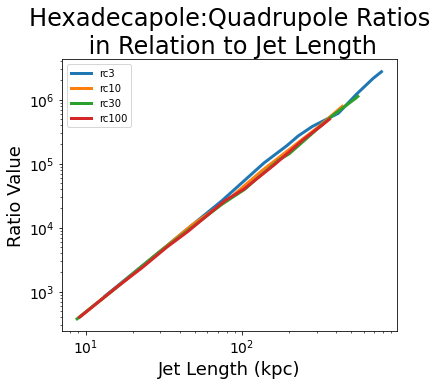

In [14]:



for key in ratio_data_lst_rc:
    print(key)
    rc = key
    ratio_data = ratio_data_lst_rc[key]

    plt.rcParams["figure.figsize"] = (6,5)
    rot_vals = ratio_data[1:, 0]
    quad1 = ratio_data[1:, 1]
    quad2 = ratio_data[1:, 2]
    quad_vals = ratio_data[1:, 3]
    hexa1 = ratio_data[1:, 4]
    hexa2 = ratio_data[1:, 5]
    hexa_vals = ratio_data[1:, 6]
    octo1 = ratio_data[1:, 7]
    octo2 = ratio_data[1:, 8]
    jet_len = ratio_data[1:, 9]

    len_vals_flt = []

    rot_vals_flt = []
    quad_vals_flt = []
    hexa_vals_flt = []
    quad1_flt = []
    quad2_flt = []
    hexa1_flt = []
    hexa2_flt = []
    octo1_flt = []
    octo2_flt = []



    for i, ratio in enumerate(quad_vals):
        dispers = float(rot_vals[i])
        
        lens = float(jet_len[i]) 
       
        ratio = float(ratio)
        rot_vals_flt.append(dispers)
        len_vals_flt.append(lens)
        quad_vals_flt.append(ratio)

    for ratio in hexa_vals:
        ratio = float(ratio)
        hexa_vals_flt.append(ratio)

    for ratio in quad1:
        ratio = float(ratio)
        quad1_flt.append(ratio)

    for ratio in quad2:
        ratio = float(ratio)
        quad2_flt.append(ratio)

    for ratio in hexa1:
        ratio = float(ratio)
        hexa1_flt.append(ratio)

    for ratio in hexa2:
        ratio = float(ratio)
        hexa2_flt.append(ratio)

#     for ratio in octo1:
#         ratio = float(ratio)
#         octo1_flt.append(ratio)

#     for ratio in octo2:
#         ratio = float(ratio)
#         octo2_flt.append(ratio)

    sq_flt = []
    for i in range(len(quad1_flt)):
        sq = math.sqrt(quad1_flt[i]**2 + quad2_flt[i]**2)
        sq_flt.append(sq)

    sq_hexa_flt = []
    for i in range(len(hexa1_flt)):
        sq = math.sqrt(hexa1_flt[i]**2 + hexa2_flt[i]**2)
        sq_hexa_flt.append(sq)
        
    sq_ratio_flt = []
    for i in range(len(sq_hexa_flt)):
        sq_ratio = sq_hexa_flt[i] / sq_flt[i]
        try:
            sq_ratio_div = sq_ratio / (len_vals_flt[i]**2)
        except ZeroDivisionError:
            sq_ratio_div = sq_ratio
        sq_ratio_flt.append(sq_ratio)
    
    
    plt.plot(len_vals_flt, sq_ratio_flt, label = "rc{}".format(rc), linewidth=3)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Jet Length (kpc)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel("Ratio Value", fontsize=18)
    plt.yticks(fontsize=14)
    plt.title("Hexadecapole:Quadrupole Ratios\n in Relation to Jet Length", fontsize=24)
    
    plt.legend()
    
plt.show()



3
10
30
100


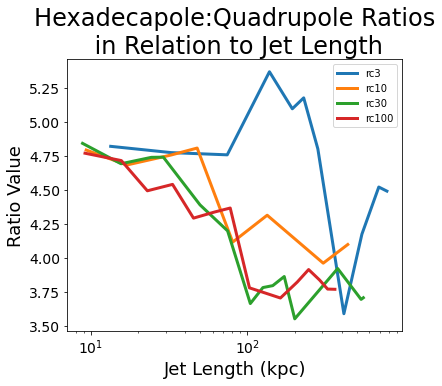

In [13]:



for key in ratio_data_lst_rc:
    print(key)
    rc = key
    ratio_data = ratio_data_lst_rc[key]

    plt.rcParams["figure.figsize"] = (6,5)
    rot_vals = ratio_data[1:, 0]
    quad1 = ratio_data[1:, 1]
    quad2 = ratio_data[1:, 2]
    quad_vals = ratio_data[1:, 3]
    hexa1 = ratio_data[1:, 4]
    hexa2 = ratio_data[1:, 5]
    hexa_vals = ratio_data[1:, 6]
    octo1 = ratio_data[1:, 7]
    octo2 = ratio_data[1:, 8]
    jet_len = ratio_data[1:, 9]

    len_vals_flt = []

    rot_vals_flt = []
    quad_vals_flt = []
    hexa_vals_flt = []
    quad1_flt = []
    quad2_flt = []
    hexa1_flt = []
    hexa2_flt = []
    octo1_flt = []
    octo2_flt = []



    for i, ratio in enumerate(quad_vals):
        dispers = float(rot_vals[i])
        
        lens = float(jet_len[i]) 
       
        ratio = float(ratio)
        rot_vals_flt.append(dispers)
        len_vals_flt.append(lens)
        quad_vals_flt.append(ratio)

    for ratio in hexa_vals:
        ratio = float(ratio)
        hexa_vals_flt.append(ratio)

    for ratio in quad1:
        ratio = float(ratio)
        quad1_flt.append(ratio)

    for ratio in quad2:
        ratio = float(ratio)
        quad2_flt.append(ratio)

    for ratio in hexa1:
        ratio = float(ratio)
        hexa1_flt.append(ratio)

    for ratio in hexa2:
        ratio = float(ratio)
        hexa2_flt.append(ratio)

#     for ratio in octo1:
#         ratio = float(ratio)
#         octo1_flt.append(ratio)

#     for ratio in octo2:
#         ratio = float(ratio)
#         octo2_flt.append(ratio)

    sq_flt = []
    for i in range(len(quad1_flt)):
        sq = math.sqrt(quad1_flt[i]**2 + quad2_flt[i]**2)
        sq_flt.append(sq)

    sq_hexa_flt = []
    for i in range(len(hexa1_flt)):
        sq = math.sqrt(hexa1_flt[i]**2 + hexa2_flt[i]**2)
        sq_hexa_flt.append(sq)
        
    sq_ratio_flt = []
    for i in range(len(sq_hexa_flt)):
        sq_ratio = sq_hexa_flt[i] / sq_flt[i]
        try:
            sq_ratio_div = sq_ratio / (len_vals_flt[i]**2)
        except ZeroDivisionError:
            sq_ratio_div = sq_ratio
        sq_ratio_flt.append(sq_ratio_div)
    
    
    plt.plot(len_vals_flt, sq_ratio_flt, label = "rc{}".format(rc), linewidth=3)
    plt.xscale("log")
    #plt.yscale("log")
    plt.xlabel("Jet Length (kpc)", fontsize=18)
    plt.xticks(fontsize=14)
    plt.ylabel("Ratio Value", fontsize=18)
    plt.yticks(fontsize=14)
    plt.title("Hexadecapole:Quadrupole Ratios\n in Relation to Jet Length", fontsize=24)
    
    plt.legend()
    
plt.show()

